In [1]:
# Imports for core lib
import torch as th
from torchvision import transforms
import numpy as np
from dataclasses import dataclass
from simple_parsing import Serializable
import logging
from pytorch3d.transforms import quaternion_to_matrix
from tqdm.auto import tqdm

In [2]:
# Imports for visualization
import cv2
from matplotlib import pyplot as plt
from matplotlib.animation import FuncAnimation
%matplotlib inline

In [3]:
from top.data.transforms import (
    Normalize,
    InstancePadding,
    DenseMapsMobilePose
)
from top.data.transforms.keypoint import (
    BoxPoints2D
)
from top.data.transforms.bounding_box import (
    SolveTranslation
)
from top.data.bbox_reg_util import CropObject
from top.data.load import (DatasetSettings, collate_cropped_img, get_loaders)
from top.data.schema import Schema
from top.train.trainer import Saver
from top.run.path_util import RunPath, get_latest_file
from top.run.app_util import update_settings
from top.run.torch_util import resolve_device

from top.model.bbox_3d import BoundingBoxRegressionModel
from top.run.draw_regressed_bbox import plot_regressed_3d_bbox

In [4]:
from top.data.objectron_sequence import ObjectronSequence
dataset_settings = ObjectronSequence.Settings()
dataset = ObjectronSequence(dataset_settings, False, None)

In [5]:
@dataclass
class TempSettings(Serializable):
    model:BoundingBoxRegressionModel.Settings = BoundingBoxRegressionModel.Settings()
        
def load_model():
    device = resolve_device('cuda')

    # Configure checkpoints + options
    ckpt = '/media/ssd/models/top/ckpt/step-117999.zip'
    opts = TempSettings()

    opts.load('/media/ssd/models/top/opts.yaml')
    opts = opts.model
    # 1. load bbox regression model
    model = BoundingBoxRegressionModel(opts).to(device)
    logging.info(F'Loading checkpoint {ckpt} ...')
    Saver(model).load(ckpt)

    return model

In [6]:
idata = iter(dataset)

In [7]:
data = next(idata)

/home/jamiecho/.cache/pypoetry/virtualenvs/top-ME4FQeLv-py3.6/lib/python3.6/site-packages/tfrecord/reader.py:150: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return np.array(list(map(fn, feature)))
/home/jamiecho/Repos/Ravel/ai604-video-object-pose/src/top/data/objectron_sequence.py:197: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  for img_bytes in out['image/en

In [8]:
# data[Schema]
seq_len = data[Schema.IMAGE].shape[0]

aos = [{k:v[i] for (k,v) in data.items()} for i in range(seq_len)]

for i in range(seq_len):
    aos[i][Schema.KEYPOINT_2D] = aos[i][Schema.KEYPOINT_2D].reshape(-1,9,3)
    
transform = transforms.Compose([
    CropObject(CropObject.Settings()),
    Normalize(Normalize.Settings(keys=(Schema.CROPPED_IMAGE,)))
])

cropped = [transform(aos[i]) for i in range(seq_len)]
# print(cropped[Schema.CROPPED_IMAGE].shape)
# print(cropped[Schema.KEYPOINT_2D].shape)

# print(aos[0][Schema.IMAGE].shape)
# print(aos[0][Schema.VISIBILITY])
# print(aos[0][Schema.KEYPOINT_2D].shape)
# print(transform(aos[0]))

# # TODO(ycho): Deal with cases where collation results < batch_size samples
# # due to short sequence or network error. For now, no such error checking is performed.
# fig, axs = plt.subplots(batch_size, sequence_length, figsize=(12,8), dpi= 200)
# for i_batch in range(batch_size):
#     for i_seq in range(sequence_length):
# #         print({k:v.shape for (k,v) in features.items()})
#         ctx = {k : v[i_batch] for (k,v) in contexts.items()}
#         feat = {k : v[i_batch,i_seq] for (k,v) in features.items()}
#         image = draw_objects_with_pose(feat)
        
#         axs[i_batch,i_seq].imshow(image)

In [9]:
# model
device = th.device('cuda')
model = load_model()
model = model.to(device)
model.eval()

# translation solver?
solve_translation = SolveTranslation()

Dropping extra args {'alpha': 0.5, 'batch_size': 64, 'dataset': {'cache': {'cache_dir': '~/.cache/ai604/', 'force_rebuild': False, 'num_samples': 8}, 'cube': {'aspect': 1.0, 'batch_size': 1, 'fov': 60, 'image_size': [256, 256], 'max_distance': 10.0, 'min_distance': 0.1, 'unstack': True, 'use_mesh': False, 'zfar': 100.0, 'znear': 0.1}, 'dataset': 'OBJECTRON', 'num_workers': 0, 'objectron': {'bucket_name': 'objectron', 'cache_dir': '~/.cache/ai604/', 'classes': ['bike', 'book', 'bottle', 'camera', 'cereal_box', 'chair', 'cup', 'laptop', 'shoe'], 'context': ['count', 'sequence_id'], 'features': ['instance_num', 'image/width', 'image/height', 'image/channels', 'image/encoded', 'object/name', 'object/translation', 'object/orientation', 'object/scale', 'object/visibility', 'point_3d', 'point_2d', 'point_num', 'camera/intrinsics', 'camera/projection'], 'local': True, 'shuffle_shards': True}, 'shuffle': False, 'use_cached_dataset': False}, 'device': 'cuda', 'eval_period': 1000, 'load_ckpt': ''

  0%|          | 0/212 [00:00<?, ?it/s]

lstsq error: [0.00464381]


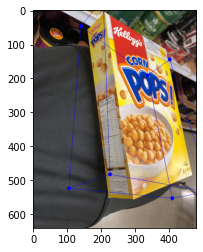

lstsq error: [0.00321326]
lstsq error: [0.00460185]
lstsq error: [0.00895309]
lstsq error: [0.00696136]
lstsq error: [0.00256781]
lstsq error: [0.00278779]
lstsq error: [0.00385412]
lstsq error: [0.00249229]
lstsq error: [0.00416954]
lstsq error: [0.00455502]
lstsq error: [0.00594728]
lstsq error: [0.00318803]
lstsq error: [0.00115007]
lstsq error: [0.00114144]
lstsq error: [0.00031554]
lstsq error: [0.00028994]
lstsq error: [0.00012976]
lstsq error: [0.0001459]
lstsq error: [0.00020892]
lstsq error: [0.0002579]
lstsq error: [0.00058611]
lstsq error: [2.1529167e-05]
lstsq error: [0.00010499]
lstsq error: [0.00071595]
lstsq error: [0.0004607]
lstsq error: [0.00033548]
lstsq error: [0.00055489]
lstsq error: [0.00212756]
lstsq error: [0.00136768]
lstsq error: [8.233321e-05]
lstsq error: [6.010381e-05]
lstsq error: [0.00233908]
lstsq error: [0.00042482]
lstsq error: [8.665287e-05]
lstsq error: [0.00066028]
lstsq error: [0.00051906]
lstsq error: [0.00010058]
lstsq error: [0.00021998]
lstsq 

In [10]:
output_images = []

fig, ax = plt.subplots(1,1)
for i in tqdm(range(seq_len)):
    data = cropped[i]
    
    with th.no_grad():
        # run inference
        crop_img = data[Schema.CROPPED_IMAGE].view(-1, 3, 224, 224)
        dim, quat = model(crop_img.to(device))
        dim2, quat2 = data[Schema.SCALE], data[Schema.QUATERNION]
#         print('D {} {}'.format(dim, dim2))
#         print('Q {} {}'.format(quat, quat2))
        trans2 = data[Schema.TRANSLATION]

        if False:
            dim = dim2
            quat = quat2
            R = quaternion_to_matrix(quat)

        R = quaternion_to_matrix(quat)

        input_image = data[Schema.IMAGE].detach().cpu()
        proj_matrix = (
            data[Schema.PROJECTION].detach().cpu().reshape(-1, 4, 4))

        translations = []
        for i in range(len(proj_matrix)):

            box_i, box_j, box_h, box_w = data[Schema.BOX_2D][i]
            box_2d = th.as_tensor(
                [box_i, box_j, box_i + box_h, box_j + box_w])
            box_2d = 2.0 * (box_2d - 0.5)

            args = {
                # inputs from dataset
                Schema.PROJECTION: proj_matrix[i],
                Schema.BOX_2D: box_2d,
                # inputs from network
                Schema.ORIENTATION: R[i],
                Schema.QUATERNION: quat[i],
                Schema.SCALE: dim[i]
            }

            # Solve translation
            translation, _ = solve_translation(args)
            translations.append(translation)

        translations = th.as_tensor(translations, dtype=th.float32)
    #     print('T {} {}'.format(translations, trans2))
        dimensions = dim.detach().cpu()
        quaternion = quat.detach().cpu()
        translations = translations.detach().cpu()

        #print(input_image.shape)
        #print(data[Schema.BOX_2D].shape)
        #print(proj_matrix.shape)
        #print(translations.shape)
        #print(dimensions.shape)
        #print(quaternion.shape)

        # draw box
        image_with_box = plot_regressed_3d_bbox(
            input_image,
            # keypoints_2d,
            # data[Schema.BOX_2D],
            data[Schema.KEYPOINT_2D],
            proj_matrix,
            dimensions,
            quaternion,
            translations)

        output_images.append(image_with_box.permute(1, 2, 0))
        ax.imshow(image_with_box.permute(1, 2, 0))
        plt.pause(0.001)

In [11]:
from IPython.display import HTML

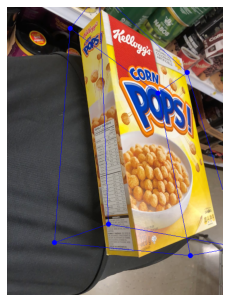

In [12]:
def _get_image(index:int):
#     return data[Schema.IMAGE][index].permute(1,2,0)
    return output_images[index]

fig, ax = plt.subplots(1,1)
fig.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=None, hspace=None)
ax.set_axis_off()
h = ax.imshow(_get_image(0))

def animate(i):
#     print('anima')
    h.set_data(_get_image(i))
anim = FuncAnimation(fig, animate, frames=len(output_images))
# HTML(anim.to_html5_video())

In [13]:
anim = FuncAnimation(fig, animate, frames=len(output_images))
anim.save(filename='/tmp/result.mp4', bitrate=4096)

### 